# Field × Advanced Analysis Workflow

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tatsuki-washimi/gwexpy/blob/main/docs/web/en/user_guide/tutorials/field_advanced_workflow.ipynb)

This tutorial demonstrates practical workflows combining ScalarField with advanced time-frequency analysis methods.

## What You'll Learn

- Extract time-series from ScalarField for analysis
- Apply HHT, STLT, Wavelet transforms
- Reconstruct analyzed data back into Field structure
- Batch processing with FieldList

## Use Case: Seismic Array Analysis

We'll analyze a 3D seismic array where each spatial point records time-varying ground motion.

In [1]:
# Suppress warnings
import warnings

import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

from gwexpy.fields import FieldList, ScalarField
from gwexpy.timeseries import TimeSeries

warnings.filterwarnings('ignore')

## Step 1: Create Synthetic Seismic Field

Simulate ground motion from a seismic wave propagating through a 3D grid.

In [2]:
# Parameters
nt, nx, ny, nz = 256, 8, 8, 4  # 256 time samples, 8×8×4 spatial grid
fs = 100  # Hz
duration = nt / fs

# Create axis coordinates
t_axis = np.arange(nt) * (1/fs) * u.s
x_axis = np.arange(nx) * 10.0 * u.m  # 10m spacing
y_axis = np.arange(ny) * 10.0 * u.m
z_axis = np.arange(nz) * 5.0 * u.m   # 5m depth spacing

# Simulate seismic wave (P-wave + surface wave)
data = np.zeros((nt, nx, ny, nz))

# P-wave (bulk wave, faster)
v_p = 3000  # m/s
f_p = 10    # Hz
for ix in range(nx):
    for iy in range(ny):
        for iz in range(nz):
            # Distance from source (corner)
            dist = np.sqrt(x_axis[ix].value**2 + y_axis[iy].value**2 + z_axis[iz].value**2)
            delay = dist / v_p
            t_vals = t_axis.value

            # P-wave with geometric spreading
            amplitude_p = 1.0 / (dist + 1)
            data[:, ix, iy, iz] += amplitude_p * np.sin(2*np.pi*f_p * (t_vals - delay)) * (t_vals > delay)

# Surface wave (slower, stronger)
v_s = 1500  # m/s
f_s = 5     # Hz
for ix in range(nx):
    for iy in range(ny):
        dist_surf = np.sqrt(x_axis[ix].value**2 + y_axis[iy].value**2)
        delay_s = dist_surf / v_s
        amplitude_s = 2.0 / (dist_surf + 1)
        data[:, ix, iy, 0] += amplitude_s * np.sin(2*np.pi*f_s * (t_vals - delay_s)) * (t_vals > delay_s)

# Add noise
data += np.random.randn(*data.shape) * 0.1

# Create ScalarField
field_seismic = ScalarField(
    data,
    axis0=t_axis,
    axis1=x_axis,
    axis2=y_axis,
    axis3=z_axis,
    axis_names=['t', 'x', 'y', 'z'],
    unit=u.m,  # Ground displacement
    name='Seismic Field',
)

print(f"Created seismic field: {field_seismic.shape}")
print(f"Time span: {duration:.2f} s")
print(f"Spatial extent: {nx*10}m × {ny*10}m × {nz*5}m")


Created seismic field: (256, 8, 8, 4)
Time span: 2.56 s
Spatial extent: 80m × 80m × 20m


## Step 2: Extract TimeSeries for Analysis

Extract time-series from specific spatial locations for detailed analysis.

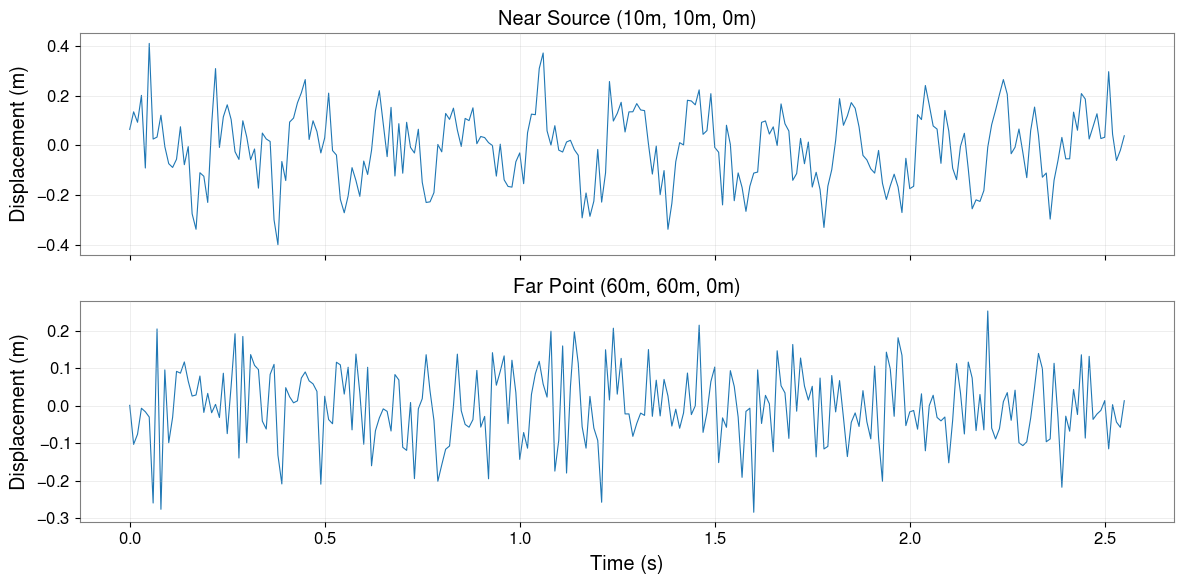

Extracted TimeSeries for analysis


In [3]:
# Extract time-series at corner (near source) and far point
slice_near = field_seismic[:, 1, 1, 0]  # Near source (keeps 4D structure)
slice_far = field_seismic[:, 6, 6, 0]   # Far from source

# Convert point-slices to 1D TimeSeries
times = slice_near.axis(0).index
ts_near = TimeSeries(slice_near.value[:, 0, 0, 0], times=times, unit=slice_near.unit, name='Near source')
ts_far = TimeSeries(slice_far.value[:, 0, 0, 0], times=times, unit=slice_far.unit, name='Far point')

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].plot(ts_near.times.value, ts_near.value, linewidth=0.8)
axes[0].set_ylabel('Displacement (m)')
axes[0].set_title('Near Source (10m, 10m, 0m)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(ts_far.times.value, ts_far.value, linewidth=0.8)
axes[1].set_ylabel('Displacement (m)')
axes[1].set_xlabel('Time (s)')
axes[1].set_title('Far Point (60m, 60m, 0m)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('Extracted TimeSeries for analysis')


## Step 3: Apply STLT to Detect Damping

Use Short-Time Laplace Transform to identify decay rates in the seismic signal.

In [4]:
# Apply STLT to detect damping (geometric spreading + attenuation)
stlt_result = ts_far.stlt(fftlength=1.0, overlap=0.5)

print(f"STLT result shape: {stlt_result.shape}")
print("Use STLT to identify decay rates (σ) at different frequencies (ω)")
print("Note: Actual visualization would show σ-ω plane with decay rate information")

STLT result shape: (4, 1, 51)
Use STLT to identify decay rates (σ) at different frequencies (ω)
Note: Actual visualization would show σ-ω plane with decay rate information


## Step 4: Batch Processing with FieldList

Process multiple spatial slices in parallel using FieldList.

In [5]:
# Extract horizontal slices at different depths
slices_at_depths = [
    field_seismic[:, :, :, iz] for iz in range(nz)
]

# Create FieldList
field_list = FieldList(slices_at_depths)

print(f"Created FieldList with {len(field_list)} depth slices")
print(f"Each slice shape: {field_list[0].shape}")

# Batch operation: compute PSD at each depth
# (This would be a real batch operation in practice)
print("\nBatch processing workflow:")
print("  1. Extract slices → FieldList")
print("  2. Apply transform → [field.fft_time() for field in field_list]")
print("  3. Aggregate results → stack or average")
print("  4. Reconstruct Field → combine processed slices")

Created FieldList with 4 depth slices
Each slice shape: (256, 8, 8, 1)

Batch processing workflow:
  1. Extract slices → FieldList
  2. Apply transform → [field.fft_time() for field in field_list]
  3. Aggregate results → stack or average
  4. Reconstruct Field → combine processed slices


## Step 5: Reconstruct Field from Processed Data

After analysis, reconstruct the Field structure to maintain 4D organization.

In [6]:
# Example: FFT in time, then reconstruct
field_freq = field_seismic.fft_time()

print(f"Frequency-domain field: {field_freq.shape}")
print(f"Axis0 domain: {field_freq.axis0_domain}")
print(f"Space domains: {field_freq.space_domains}")

# Inverse transform
field_reconstructed = field_freq.ifft_time()

# Verify reconstruction
max_error = np.max(np.abs(field_seismic.value - field_reconstructed.value))
print(f"\nReconstruction error: {max_error:.2e} m")
print("4D structure preserved through FFT → IFFT cycle ✓")


Frequency-domain field: (129, 8, 8, 4)
Axis0 domain: frequency
Space domains: {'x': 'real', 'y': 'real', 'z': 'real'}

Reconstruction error: 1.33e-15 m
4D structure preserved through FFT → IFFT cycle ✓


## Summary: Field × Advanced Analysis Best Practices

### Workflow Pattern

```
ScalarField (4D)
    ↓ extract
TimeSeries (1D) → Advanced Analysis (HHT, STLT, Wavelet)
    ↓ results
Metrics / Features
    ↓ aggregate
ScalarField (4D) ← Reconstructed
```

### Key Techniques

1. **Extraction**: `field[:, x, y, z].to_timeseries()` for point analysis
2. **Batch Processing**: Use FieldList for parallel operations
3. **Transform Cycle**: `fft_time()` → process → `ifft_time()` preserves 4D
4. **Slicing**: Maintain 4D structure even when selecting single indices

### When to Use What

- **Point analysis**: Extract TimeSeries, apply HHT/STLT/Wavelet
- **Spatial patterns**: Use `fft_space()` for k-space analysis
- **Batch operations**: FieldList for multiple realizations
- **Full 4D transforms**: `fft_time()` + `fft_space()` for frequency-wavenumber